Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


Step 2: Load Data

In [2]:

data = pd.read_csv('../Data Engineering/Data/reports/curated_final_ale.csv')
data = data.drop(columns=['department_y', 'role_y'])
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107348 entries, 0 to 107347
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   employee_id              107348 non-null  int64  
 1   name                     107348 non-null  object 
 2   department_x             107348 non-null  object 
 3   role_x                   107348 non-null  object 
 4   email                    107348 non-null  object 
 5   skill_id                 107348 non-null  int64  
 6   skill_level              107348 non-null  object 
 7   skill_progress           107348 non-null  int64  
 8   skill_name               107348 non-null  object 
 9   employee_certificate_id  100917 non-null  float64
 10  certification_id         100917 non-null  float64
 11  certification_name       100917 non-null  object 
 12  course_id                107348 non-null  int64  
 13  course_name              107348 non-null  object 
dtypes: f

Step 3: EDA (Exploratory Data Analysis)

employee_id                   0
name                          0
department_x                  0
role_x                        0
email                         0
skill_id                      0
skill_level                   0
skill_progress                0
skill_name                    0
employee_certificate_id    6431
certification_id           6431
certification_name         6431
course_id                     0
course_name                   0
dtype: int64


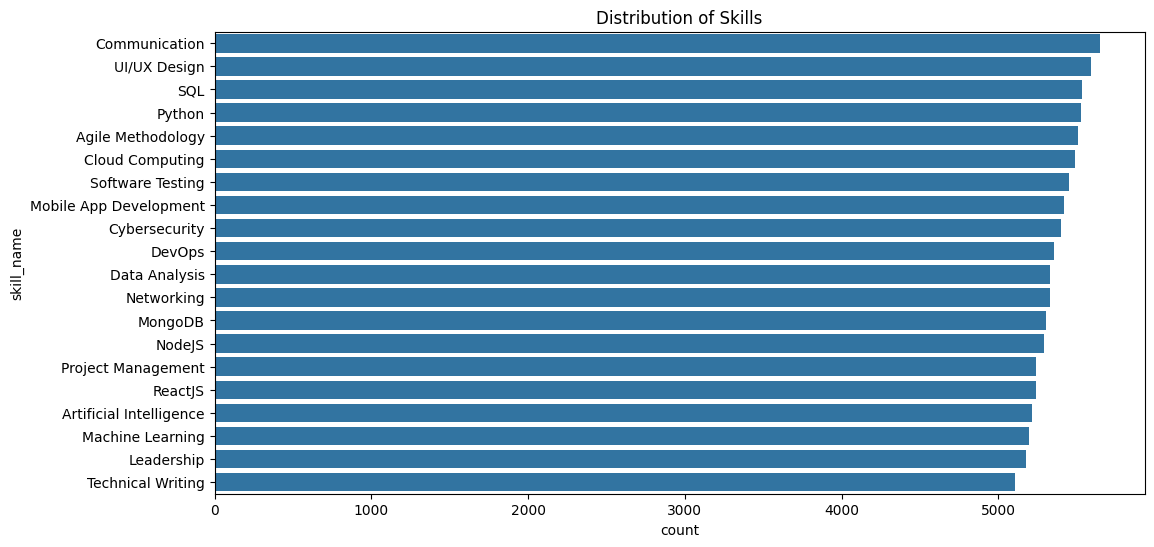

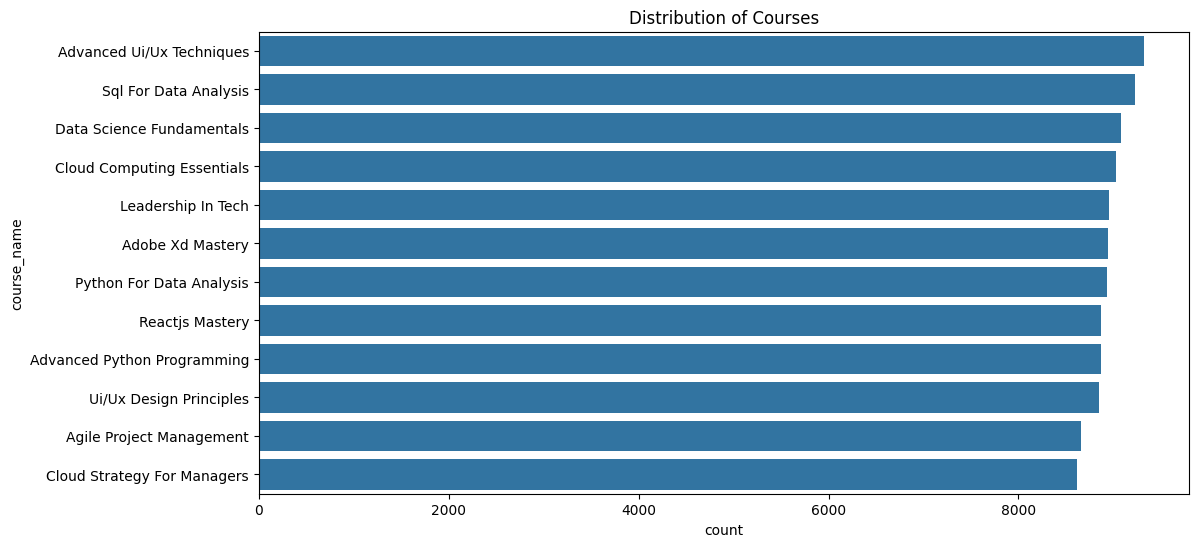

In [3]:
print(data.isnull().sum())
plt.figure(figsize=(12, 6))
sns.countplot(y='skill_name', data=data, order=data['skill_name'].value_counts().index)
plt.title('Distribution of Skills')
plt.show()
plt.figure(figsize=(12, 6))
sns.countplot(y='course_name', data=data, order=data['course_name'].value_counts().index)
plt.title('Distribution of Courses')
plt.show()


Step 4: Data Preprocessing

In [4]:

data.dropna(inplace=True)

level_mapping = {'Beginner': 1, 'Intermediate': 2, 'Advanced': 3}
data['skill_level'] = data['skill_level'].map(level_mapping)

data = pd.get_dummies(data, columns=['role_x'], drop_first=True)

print(data.head())


   employee_id          name department_x               email  skill_id  \
0        35969  Chloe Foster  Engineering  jbaker@example.net        10   
1        35969  Chloe Foster  Engineering  jbaker@example.net        10   
2        35969  Chloe Foster  Engineering  jbaker@example.net        10   
3        35969  Chloe Foster  Engineering  jbaker@example.net        10   
4        35969  Chloe Foster  Engineering  jbaker@example.net        10   

   skill_level  skill_progress skill_name  employee_certificate_id  \
0            2              15     DevOps                  12061.0   
1            2              15     DevOps                   2143.0   
2            2              15     DevOps                  29757.0   
3            2              15     DevOps                  68550.0   
4            2              15     DevOps                   9481.0   

   certification_id                                 certification_name  \
0              13.0  Certified Information Systems Sec

Step 5: Feature Engineering

In [5]:
skills_matrix = data.pivot_table(index='employee_id', columns='skill_id', values='skill_level', fill_value=0)
print(skills_matrix.head())


skill_id      1    2    3    4    5    6    7    8    9    10   11   12   13  \
employee_id                                                                    
1008         0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0   
1011         3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1027         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0   
1047         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0   
1049         2.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0   

skill_id      14   15   16   17   18   19   20  
employee_id                                     
1008         3.0  0.0  0.0  0.0  0.0  0.0  0.0  
1011         0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1027         0.0  1.0  0.0  0.0  0.0  0.0  2.0  
1047         0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1049         0.0  0.0  0.0  0.0  0.0  0.0  0.0  


Step 6: Model Selection and Training

In [6]:

X = skills_matrix
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

knn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_model.fit(X_train)

distances, indices = knn_model.kneighbors(X_test)

employee_idx = 0  # Choose the first employee in the test set

original_employee_id = X_test.index[employee_idx]
similar_employees = indices[employee_idx]

print("Employees similar to Employee ID:", original_employee_id)
print("Similar Employee IDs:", X_train.index[similar_employees]) 


Employees similar to Employee ID: 23819
Similar Employee IDs: Index([2040, 1590, 75318, 25582, 75509], dtype='int64', name='employee_id')


Step 7: Course Recommendation & Model Performance Results

In [7]:

def recommend_courses(employee_id, n_recommendations=3):

    distances, indices = knn_model.kneighbors([skills_matrix.loc[employee_id]])
    similar_employees = indices[0]

    recommended_courses = []
    for similar_employee in similar_employees:
        employee_courses = data[data['employee_id'] == skills_matrix.index[similar_employee]]['course_name'].unique()
        recommended_courses.extend(employee_courses)
    
    recommended_courses = list(set(recommended_courses) - set(data[data['employee_id'] == employee_id]['course_name']))
    return recommended_courses[:n_recommendations]

def evaluate_recommendations(X_test, k=3):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for employee_id in X_test.index:

        actual_courses = set(data[data['employee_id'] == employee_id]['course_name'].unique())
   
        recommended_courses = set(recommend_courses(employee_id, n_recommendations=k))
        print(f"Employee ID: {employee_id}")
        print(f"Actual Courses: {actual_courses}")
        print(f"Recommended Courses: {recommended_courses}")
        print("----------")
        true_positives += len(actual_courses & recommended_courses)  # Courses recommended and taken
        false_positives += len(recommended_courses - actual_courses)  # Courses recommended but not taken
        false_negatives += len(actual_courses - recommended_courses)  # Courses taken but not recommended

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

precision, recall, f1 = evaluate_recommendations(X_test, k=3)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Employee ID: 23819
Actual Courses: {'Advanced Python Programming', 'Cloud Computing Essentials', 'Reactjs Mastery'}
Recommended Courses: {'Advanced Ui/Ux Techniques', 'Leadership In Tech', 'Python For Data Analysis'}
----------
Employee ID: 47852
Actual Courses: {'Cloud Strategy For Managers'}
Recommended Courses: {'Leadership In Tech', 'Python For Data Analysis', 'Data Science Fundamentals'}
----------
Employee ID: 28091
Actual Courses: {'Agile Project Management', 'Cloud Strategy For Managers'}
Recommended Courses: {'Leadership In Tech', 'Advanced Python Programming', 'Data Science Fundamentals'}
----------
Employee ID: 9473
Actual Courses: {'Leadership In Tech'}
Recommended Courses: {'Advanced Ui/Ux Techniques', 'Advanced Python Programming', 'Python For Data Analysis'}
----------
Employee ID: 91540
Actual Courses: {'Sql For Data Analysis'}
Recommended Courses: {'Leadership In Tech', 'Ui/Ux Design Principles', 'Agile Project Management'}
----------
Employee ID: 35940
Actual Courses:

In [8]:
def evaluate_knn_model(X_train, X_test, knn_model):
    distances, indices = knn_model.kneighbors(X_test)
    avg_distances = distances.mean(axis=1)
    
    overall_avg_distance = avg_distances.mean()
    return overall_avg_distance

# Evaluate the model
overall_avg_distance = evaluate_knn_model(X_train, X_test, knn_model)
print(f"Overall average distance between test employees and their nearest neighbors: {overall_avg_distance}")


Overall average distance between test employees and their nearest neighbors: 0.02745490427652312
